# **Random Forest Classifier**

In [2]:
import pandas as pd

In [3]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [4]:
print(f"Number of data points in the training set: {train_data.shape[0]}")
print(f"Number of data points in the test set: {test_data.shape[0]}")

Number of data points in the training set: 373598
Number of data points in the test set: 35406


Drop unused features

In [5]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [6]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

## Preprocessing Pipeline

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

Given that this model supports both categorical and numerical features, in the various attempts to find the best model, combinations of both were tried out. This is why the pipeline also supports categorical features

In [8]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', "passthrough", cat_features)
    ])

## Random Forest

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score,  confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTEENN,  SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

Given the high amount of parameters and combinations of them, we decided to adopt a randomized search approach over the parameter space, given the high dimensionality of the latter 

NOTE: resempling is added in the preprocessing pipeline in order to be applied olny on training data.

In [10]:
resampling = SMOTETomek(sampling_strategy=0.85, random_state=42)
clf = LGBMClassifier(boosting_type='rf', is_unbalance=True, importance_type='gain', verbose=-1, random_state=0, n_jobs=1)

# Create the model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampling", resampling),
        ("clf", clf)]
)

# Define the hyperparameter grid
params = {
    'clf__n_estimators': [25, 50, 100, 200],
    'clf__max_depth': [2, 3, 4, 5, 6, 8],
    'clf__min_child_samples': [5, 7, 10, 15, 20, 30, 50],
    'clf__colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'clf__subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
}

# Define the scoring metrics
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=50, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels.values.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('resampling',
                                              SMOTETomek(random_state=42,
                                                         sampling_strategy=0.85)),
                                             ('clf'...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores:

In [11]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.6573, Std: 0.0100
Specificity - Mean: 0.7118, Std: 0.0032
Accuracy - Mean: 0.7046, Std: 0.0018
Precision - Mean: 0.2589, Std: 0.0017
Recall - Mean: 0.6573, Std: 0.0100
Roc_auc - Mean: 0.7472, Std: 0.0034
F1 - Mean: 0.3715, Std: 0.0031


### Test scores:

Accuracy: 0.671
Recall: 0.708
Precision: 0.266
Sensitivity: 0.708
Specificity: 0.665
F1 Score: 0.387
ROC AUC Score: 0.687


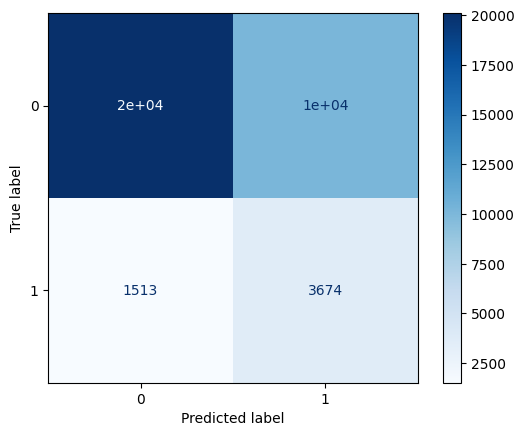

In [12]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [13]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     30219
           1       0.27      0.71      0.39      5187

    accuracy                           0.67     35406
   macro avg       0.60      0.69      0.58     35406
weighted avg       0.83      0.67      0.72     35406



In [14]:
# Get the best estimator from the RandomizedSearchCV
best_model = rscv.best_estimator_
best_dt = best_model.named_steps["clf"]

cat_transformer = rscv.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"] 
cat_feature_names = [] if cat_transformer == 'passthrough' else cat_transformer.get_feature_names_out(cat_features)

all_features = numeric_features + cat_feature_names


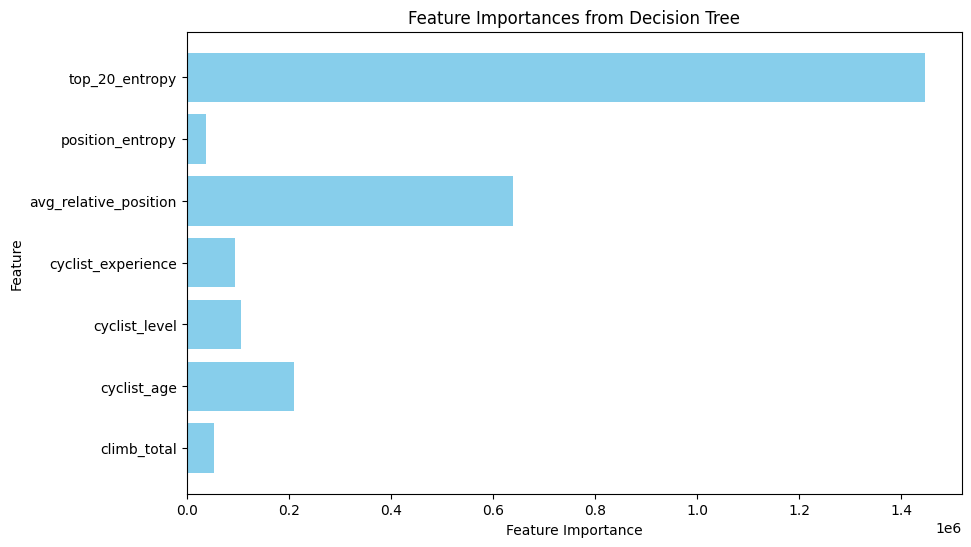

In [15]:
# Print feature importance
feature_importances = best_dt.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(all_features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

This plot displays the most relevant features utilized by the random forest model. Comparing it to the feature importance plot of the decision tree, it is evident that `top_20_entropy` and `avg_relative_position` have swapped positions as the most and second most important features. Additionally, this model demonstrates a more balanced utilization of the remaining features overall.

## Model Save

In [ ]:
import joblib
import os

os.makedirs('best_models', exist_ok=True)
joblib.dump(best_model, 'best_models/rf.pkl')

['best_models/rf.pkl']

Since GB and RF are models based on decision trees, not all combinations were exhaustively tested. Instead, the focus was on random oversampling, undersampling, and hybrid techniques. In both cases, as with decision trees, the best-performing resampling method was SMOTETomek, yielding the most balanced and superior results.